In [8]:
import pandas as pd
import nltk
nltk.download('punkt')
import textract

[nltk_data] Downloading package punkt to /home/abhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
data = pd.read_csv('mueller_report.csv')
data.head()

,page,line,text
0,1,1,U.S. Department of Justice
1,1,2,"AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA"
2,1,3,Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e)
3,1,4,Report On The Investigation Into
4,1,5,Russian InterferenceIn The


In [10]:
data = data.dropna(axis=0, how='any')

# Preprocessing

In [11]:
import re
import string
sentences = data.iloc[:,-1].values
k = []
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence
for i in sentences:
    j = i.lower()
    l = j.translate(str.maketrans('', '', string.punctuation)).strip()
    m = clean_text(l)
    k.append(m)
k[:10]

['us department of justice',
 'attaraecerlc predtiet mtt cea ttia',
 'ma ertalprn eeteduader fed crhtt',
 'report on the investigation into',
 'russian interferencein the',
 'presidentialelection',
 'volume of ii',
 'special counsel robert mueller iii',
 'submitted pursuant to cfr',
 'washington dc']

# Loading the facebook infersent model

In [15]:
from models import InferSent
import torch

In [21]:
from models import InferSent
model_version = 2
MODEL_PATH = "/home/abhi/Machine learning/InferSent/encoder/infersent%s.pkl"%model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH_2 = 'infersent_sentence_encoder/GloVe/glove.840B.300d.txt'
W2V_PATH_1 = '/home/abhi/Machine learning/InferSent/glove.6B.50d.txt'
W2V_PATH = '/home/abhi/Machine learning/InferSent/fastText/crawl-300d-2M.vec'

model.set_w2v_path(W2V_PATH)

model.build_vocab(sentences, tokenize=True)
embs = model.encode(sentences, tokenize=True)


Found 12586(/17056) words with w2v vectors
Vocab size : 12586


# Embedding sentences

In [22]:
model.build_vocab(sentences, tokenize=True)
embs = model.encode(sentences, tokenize=True)

Found 12586(/17056) words with w2v vectors
Vocab size : 12586


# Clustering according to sentence similarity

In [40]:
import nmslib
import numpy as np
NTHREADS = 8
#creating a batch wise implementation
def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index
def get_knns(index, vecs, k=4):#KNN
    return zip(*index.knnQueryBatch(vecs, k=k,num_threads=NTHREADS))
nn_wvs = create_index(embs)
to_frame = lambda x: pd.DataFrame(np.array(x)[:,1:])
idxs, dists = map(to_frame, get_knns(nn_wvs, embs, k=10))
catted = pd.concat([idxs.stack().to_frame('idx'), dists.stack().to_frame('dist')], axis=1).reset_index().drop('level_1',1).rename(columns={'level_0': 'v1', 'idx': 'v2'})

In [41]:
catted.head(10)

,v1,v2,dist
0,0,17252,0.000000
1,0,17751,0.000000
2,0,18099,0.000000
3,0,18196,0.000000
4,0,18275,0.000000
5,0,18584,0.000000
6,0,18586,0.000000
7,0,952,0.000000
8,0,966,0.000000
9,1,3563,0.642763


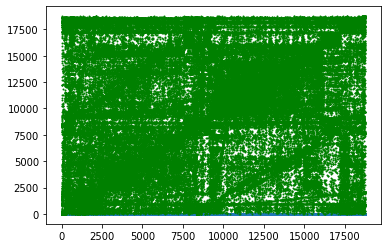

In [57]:
x,y,z = catted['v1'],catted['v2'],catted['dist']
plt.scatter(x,z,s=1)
plt.scatter(x,y,s=1,color='green')



# Created by Abhishek Ratnam ph-9521214240, email-anshu98@outlook.com,10-Nov-2019,14:30